In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH=os.environ.get('SCRATCH')+'/'

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)
    
%load_ext autoreload
%autoreload 2

from orographicPrecipitation.observationsAndERA5.mountainUtils import *; from tools.generalTools import *; from tools.BLtools import *
from tools.e5tools import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

In [2]:
from scipy import special
def linregress_xr_2(x,y,dim='time'):
    nt = len(x[dim])
    assert nt==len(y[dim])
    ssxm = nt*x.var(dim=dim)
    ssym = nt*y.var(dim=dim)
    ssxym = nt*xr.cov(x,y,dim=dim)       
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 * x.isel({dim:0})**0
    
    return xr.merge([slope.rename('slope'),(r**2).rename('rsquared'),pval.rename('pvalue')])

def fdr(pvalues,alpha):
    sortidx = np.argsort(pvalues)
    psorted = pvalues[sortidx]
    psorted[np.isnan(psorted)]=1
    nval = len(pvalues)
    ifdr = np.argmax((psorted < alpha*np.arange(1,nval+1)/nval)[::-1])
    if ifdr == 0 and psorted[-1]>= alpha:
        ifdr=nval-1
    ifdr = nval - ifdr - 1
    return sortidx[:ifdr]

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

In [3]:
def sel_jja(da):
    return da.sel(time=((da['time.month']>=6)&(da['time.month']<=8))).groupby('time.year').mean()


In [16]:
#import dask
#dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
#from dask.distributed import Client
#client=Client()
#
#
#%time era5u850_monthly = e5_monthly_timeseries("128_131_u",years=range(2001,2021),box=[60,120,14,16],level=850.,chunks=None)
#era5u850_monthly.to_netcdf("/global/cscratch1/sd/qnicolas/temp/e5.monthly.128_131_u.850.SouthAsia.2001-2020.nc")


35.34262204170227
CPU times: user 3.15 s, sys: 580 ms, total: 3.73 s
Wall time: 36.3 s


In [6]:
era5u850_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.128_131_u.850.SouthAsia.2001-2020.nc")

In [7]:
gpm_pr_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG.monthly.2001-2020.nc")
era5100u_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_246_100u.2001-2020.nc")
era5100v_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_247_100v.2001-2020.nc")

topo_midres = xr.open_dataarray("/global/cscratch1/sd/qnicolas/ETOPO1_Ice_g_gmt4_coarse.nc")
topo_midres = np.maximum(0.,topo_midres)

In [9]:
%%time
gpm_pr_jja_yearly=sel_jja(gpm_pr_monthly)
era5100u_jja_yearly = sel_jja(era5100u_monthly)
era5100v_jja_yearly = sel_jja(era5100v_monthly)

CPU times: user 4.22 s, sys: 5.79 s, total: 10 s
Wall time: 13.2 s


In [19]:
%time u850_timeseries = sel_jja(era5u850_monthly).mean(['latitude','longitude']).load()

CPU times: user 168 ms, sys: 2.01 ms, total: 170 ms
Wall time: 308 ms


In [20]:
u_timeseries = era5100u_monthly.sel(latitude = slice(16,14),longitude=slice(60,120)).mean(['latitude','longitude'])
u_timeseries = sel_jja(u_timeseries)

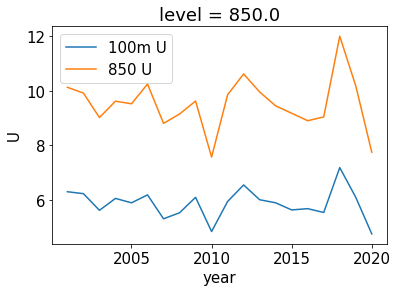

In [22]:
u_timeseries.plot(label='100m U')
u850_timeseries.plot(label='850 U')
plt.legend()

In [27]:
u_timeseries = u850_timeseries

# Initial figure

In [28]:
thresh = np.percentile(u_timeseries,85)
condmean = gpm_pr_jja_yearly.where(u_timeseries>=thresh).mean('year')
allmean = gpm_pr_jja_yearly.mean('year')

In [29]:
ucondmean = era5100u_jja_yearly.where(u_timeseries>=thresh).mean('year')
umean = era5100u_jja_yearly.mean('year')
vcondmean = era5100v_jja_yearly.where(u_timeseries>=thresh).mean('year')
vmean = era5100v_jja_yearly.mean('year')

In [23]:
def cross_section(prjja,prond,orog,lon1,lon2,lat,ax,second=True):
    """Plot a cross section of orography, JJA and OND precip at a given latitude and between two given longitudes """
    ax2=ax.twinx()
    prjja.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='g',label='Mean precipitation',linewidth=3)#
    if second:
        prond.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax2,color='dodgerblue',label='3 windiest years',linewidth=3)#
    orog.sel(longitude=slice(lon1,lon2)).sel(latitude=lat,method='nearest').plot(ax=ax,color='k',label='Surface elevation ',linewidth=3)#
    
    ax.set_xlabel('')
    ax.set_ylabel('Z (m)')
    ax.set_xlim((lon1,lon2))
    ticklon=range(lon1,lon2,10)[1:]
    ax.set_xticks(ticklon)
    ax.set_xticklabels(["%i°E"%t for t in ticklon])
    ax.set_title('')
    ax2.set_title('')
    
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    return ax2

<AxesSubplot:label='0e4dc433-dd1c-4eb0-95c1-4a961b6d4b3a', xlabel='longitude', ylabel='precipitation'>

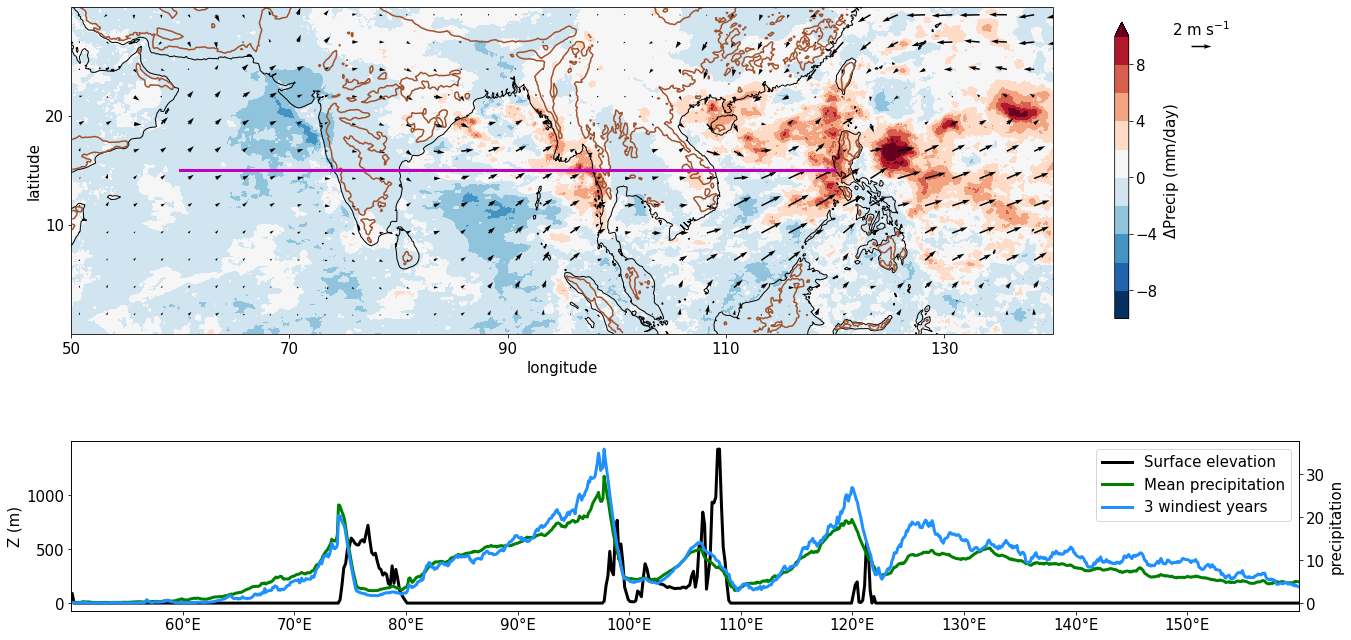

In [81]:
fig = plt.figure(figsize=(22,12))
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios= [5,2],figure=fig)
ax1 = fig.add_subplot(spec[0],projection= ccrs.PlateCarree())
ax2 = fig.add_subplot(spec[1])


lon1,lon2 = 50,160
lat = 15

(condmean-allmean).sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contourf(ax=ax1,levels=np.linspace(-10,10,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':r'$\Delta$Precip (mm/day)'})
topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())



u=ucondmean-umean
v=vcondmean-vmean
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=10
m=n
ibeg=3
iend=-1
Q=ax1.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.1,width=1.5,units='dots',transform=ccrs.PlateCarree())
# Quiver key (reference wind arrow)
qk = ax1.quiverkey(Q, 1.15, 0.88, 2, r'2 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.plot([60,120],[15,15],color='m',linewidth=3)
ax1.set_title("")
ax1.set_xticks(range(50,140,20), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)
    

cross_section(allmean,condmean,topo_midres,lon1,lon2,lat,ax2,second=True)

# regressions

In [30]:
%time prreg = linregress_xr_2(u_timeseries,gpm_pr_jja_yearly,dim='year')
prreg_masked = (prreg.slope) / fdr_xr_2d(prreg.pvalue,0.1)

CPU times: user 7 s, sys: 3.11 s, total: 10.1 s
Wall time: 9.39 s


In [31]:
%%time 
ureg = linregress_xr_2(u_timeseries,era5100u_jja_yearly,dim='year')
vreg = linregress_xr_2(u_timeseries,era5100v_jja_yearly,dim='year')
mask = (fdr_xr_2d(ureg.pvalue,0.1)+fdr_xr_2d(vreg.pvalue,0.1))>0
ureg_masked = ureg.slope / mask
vreg_masked = vreg.slope / mask

CPU times: user 2.44 s, sys: 387 ms, total: 2.83 s
Wall time: 2.63 s


(50.0, 140.0)

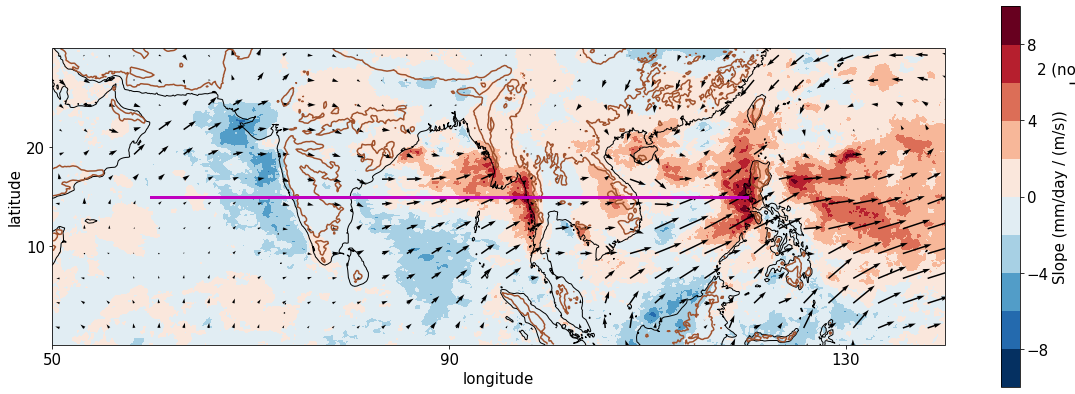

In [25]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

prreg.slope.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contourf(ax=ax1,levels=np.linspace(-10,10,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day / (m/s))'})
topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

u = ureg.slope
v = vreg.slope
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=10
m=n
ibeg=3
iend=-1
Q=ax1.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.1,width=1.5,units='dots',transform=ccrs.PlateCarree())
qk = ax1.quiverkey(Q, 1.15, 0.88, 2, r'2 (nondim)', labelpos='N',
                coordinates='axes',color='k')

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.plot([60,120],[15,15],color='m',linewidth=3)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)



(50.0, 140.0)

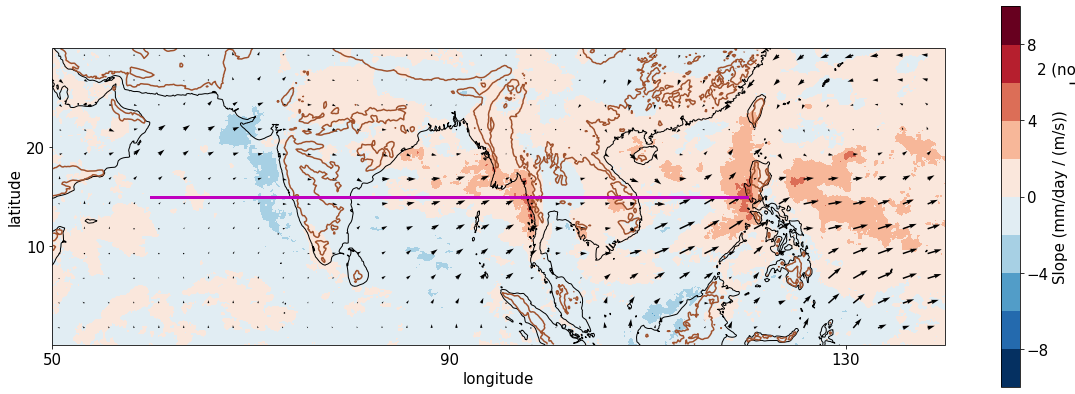

In [32]:
# with 850mb wind

(50.0, 140.0)

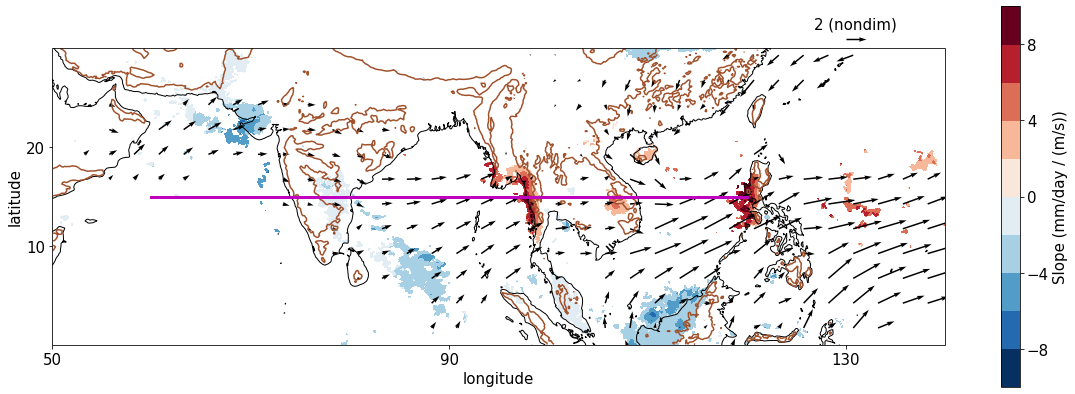

In [26]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

prreg_masked.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contourf(ax=ax1,levels=np.linspace(-10,10,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day / (m/s))'})
topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

u = ureg_masked
v = vreg_masked
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=10
m=n
ibeg=3
iend=-1
Q=ax1.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.1,width=1.5,units='dots',transform=ccrs.PlateCarree())
qk = ax1.quiverkey(Q, 0.9,1.03, 2, r'2 (nondim)', labelpos='N',
               coordinates='axes',color='k')
  
ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.plot([60,120],[15,15],color='m',linewidth=3)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)

(50.0, 140.0)

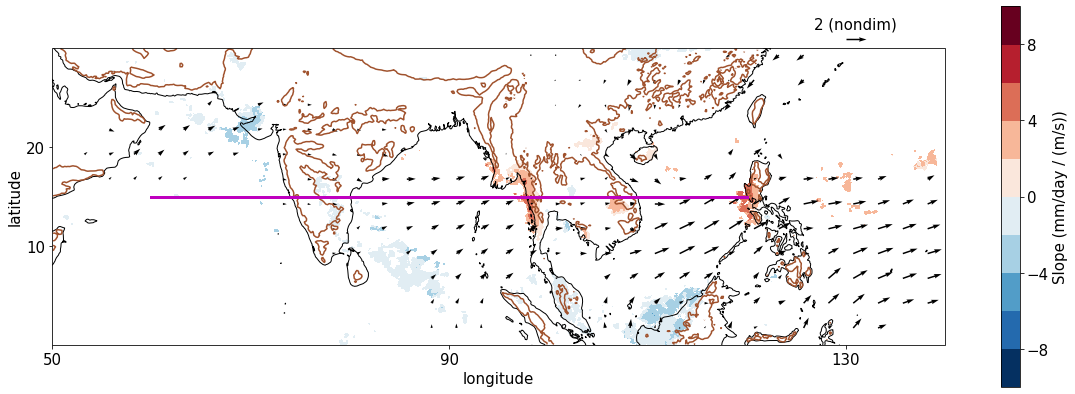

In [33]:
#850 mb

# with a longer precip dataset

In [6]:
%time era5100u_monthly_long = e5_monthly_timeseries("228_246_100u",years=range(1979,2021),box=[50,160,0,30])
%time era5100v_monthly_long = e5_monthly_timeseries("228_247_100v",years=range(1979,2021),box=[50,160,0,30])
era5100u_jja_yearly_long = sel_jja(era5100u_monthly_long)
era5100v_jja_yearly_long = sel_jja(era5100v_monthly_long)

2.6690478324890137
CPU times: user 3.28 s, sys: 576 ms, total: 3.85 s
Wall time: 6.5 s
2.7356059551239014
CPU times: user 3.4 s, sys: 540 ms, total: 3.94 s
Wall time: 5.51 s


In [7]:
cru = xr.open_dataset(SCRATCH+"CRUTSv4.06/cru_ts4.06.1901.2021.pre.dat.nc")
cru = cru.pre.sel(time=((cru['time.year']>=1979)&(cru['time.year']<2021)))
cru_pr_jja_yearly=sel_jja(cru).rename(lat='latitude',lon='longitude')


In [46]:
u_timeseries = era5100u_jja_yearly_long.sel(latitude = slice(16,14),longitude=slice(60,120)).mean(['latitude','longitude']).load()

In [55]:
%time prreg = linregress_xr_2(u_timeseries,cru_pr_jja_yearly,dim='year')
prreg_masked = (prreg.slope) / fdr_xr_2d(prreg.pvalue,0.1)

CPU times: user 360 ms, sys: 156 ms, total: 517 ms
Wall time: 472 ms


In [56]:
%%time 
ureg = linregress_xr_2(u_timeseries,era5100u_jja_yearly_long,dim='year')
vreg = linregress_xr_2(u_timeseries,era5100v_jja_yearly_long,dim='year')
mask = (fdr_xr_2d(ureg.pvalue,0.1)+fdr_xr_2d(vreg.pvalue,0.1))>0
ureg_masked = ureg.slope / mask
vreg_masked = vreg.slope / mask

CPU times: user 2.39 s, sys: 191 ms, total: 2.58 s
Wall time: 3.74 s


(50.0, 140.0)

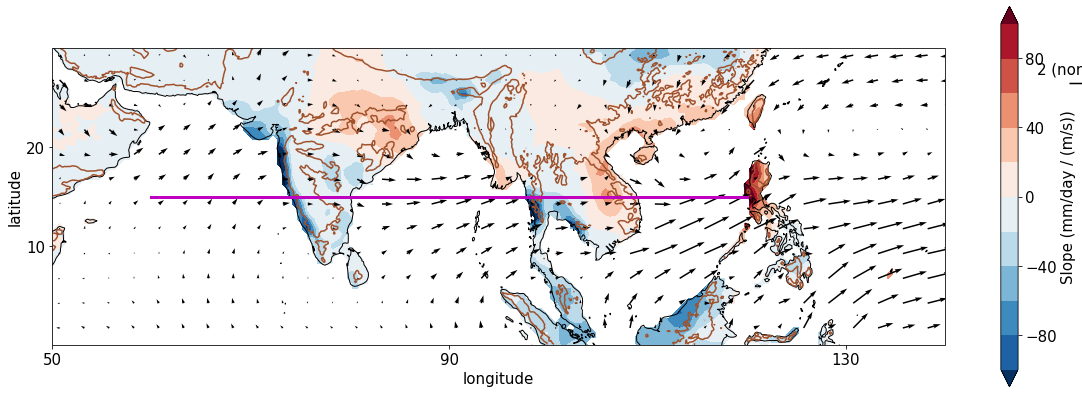

In [64]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

prreg.slope.plot.contourf(ax=ax1,levels=np.linspace(-100,100,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day / (m/s))'})
topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

u = ureg.slope
v = vreg.slope
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=10
m=n
ibeg=3
iend=-1
Q=ax1.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.1,width=1.5,units='dots',transform=ccrs.PlateCarree())
qk = ax1.quiverkey(Q, 1.15, 0.88, 2, r'2 (nondim)', labelpos='N',
                coordinates='axes',color='k')

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.plot([60,120],[15,15],color='m',linewidth=3)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)



(50.0, 140.0)

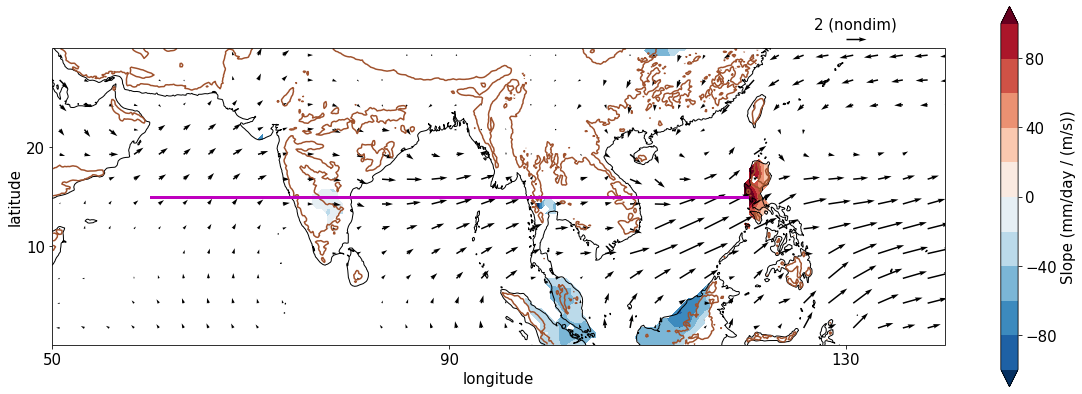

In [65]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

prreg_masked.plot.contourf(ax=ax1,levels=np.linspace(-100,100,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day / (m/s))'})
topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

u = ureg_masked
v = vreg_masked
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=10
m=n
ibeg=3
iend=-1
Q=ax1.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.1,width=1.5,units='dots',transform=ccrs.PlateCarree())
qk = ax1.quiverkey(Q, 0.9,1.03, 2, r'2 (nondim)', labelpos='N',
               coordinates='axes',color='k')
  
ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.plot([60,120],[15,15],color='m',linewidth=3)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)

# Local regressions

In [91]:
cru = xr.open_dataset(SCRATCH+"CRUTSv4.06/cru_ts4.06.1901.2021.pre.dat.nc")
cru = cru.pre.sel(time=((cru['time.year']>=1960)&(cru['time.year']<2021)))
cru_pr_jja_yearly_1960_2020=sel_jja(cru).rename(lat='latitude',lon='longitude')/31


In [34]:
%time era5100u_monthly_1979_2020 = e5_monthly_timeseries("228_246_100u",years=range(1979,2021),box=[50,160,0,30])
%time era5100v_monthly_1979_2020 = e5_monthly_timeseries("228_247_100v",years=range(1979,2021),box=[50,160,0,30])


2.4481074810028076
CPU times: user 3.18 s, sys: 324 ms, total: 3.51 s
Wall time: 3.59 s
2.686432123184204
CPU times: user 3.43 s, sys: 348 ms, total: 3.78 s
Wall time: 3.84 s


In [35]:
%time era5100u_monthly_1960_1978 = e5_monthly_timeseries("228_246_100u",years=range(1960,1979),box=[50,160,0,30])
%time era5100v_monthly_1960_1978 = e5_monthly_timeseries("228_247_100v",years=range(1960,1979),box=[50,160,0,30])


0.1289527416229248
CPU times: user 464 ms, sys: 160 ms, total: 624 ms
Wall time: 917 ms
0.1275479793548584
CPU times: user 475 ms, sys: 145 ms, total: 620 ms
Wall time: 865 ms


In [36]:
era5100u_monthly_1960_2020 = xr.concat((era5100u_monthly_1960_1978,era5100u_monthly_1979_2020),dim='time')
era5100v_monthly_1960_2020 = xr.concat((era5100v_monthly_1960_1978,era5100v_monthly_1979_2020),dim='time')

In [37]:
era5100u_jja_yearly_1960_2020 = sel_jja(era5100u_monthly_1960_2020)
era5100v_jja_yearly_1960_2020 = sel_jja(era5100v_monthly_1960_2020)

In [38]:
era5windspeed =  np.sqrt(era5100u_jja_yearly_1960_2020**2+era5100v_jja_yearly_1960_2020**2)

In [92]:
%time prregwind = linregress_xr_2(era5windspeed,cru_pr_jja_yearly_1960_2020,dim='year')
prregwind_masked = (prregwind.slope) / fdr_xr_2d(prregwind.pvalue,0.1)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 1.43 s, sys: 223 ms, total: 1.65 s
Wall time: 743 ms


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Precip reg onto wind with fdr')

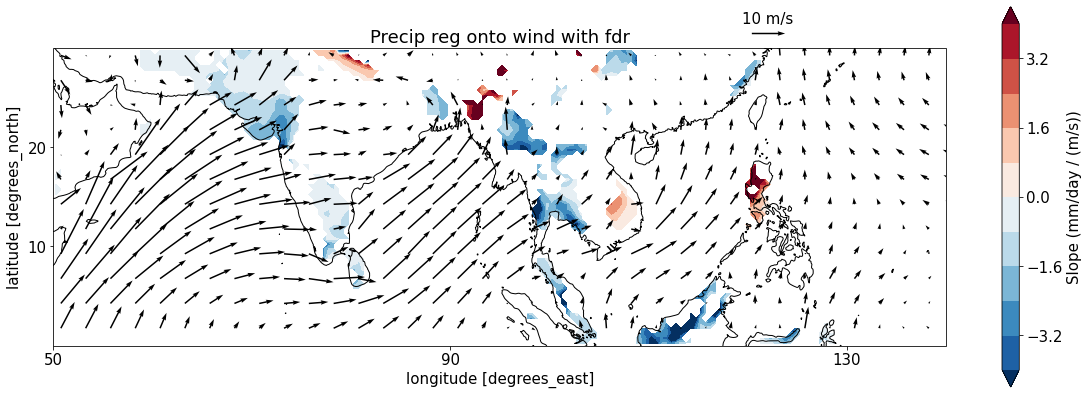

In [96]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

prregwind_masked.plot.contourf(ax=ax1,levels=np.linspace(-4,4,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day / (m/s))'})
#topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

u = era5100u_jja_yearly_1960_2020.mean('year')
v = era5100v_jja_yearly_1960_2020.mean('year')
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=10
m=n
ibeg=3
iend=-1
Q=ax1.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.3,width=1.5,units='dots',transform=ccrs.PlateCarree())
qk = ax1.quiverkey(Q, 0.8, 1.05, 10, r'10 m/s', labelpos='N',
                coordinates='axes',color='k')

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)


plt.title('Precip reg onto wind with fdr')

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Precip reg onto wind')

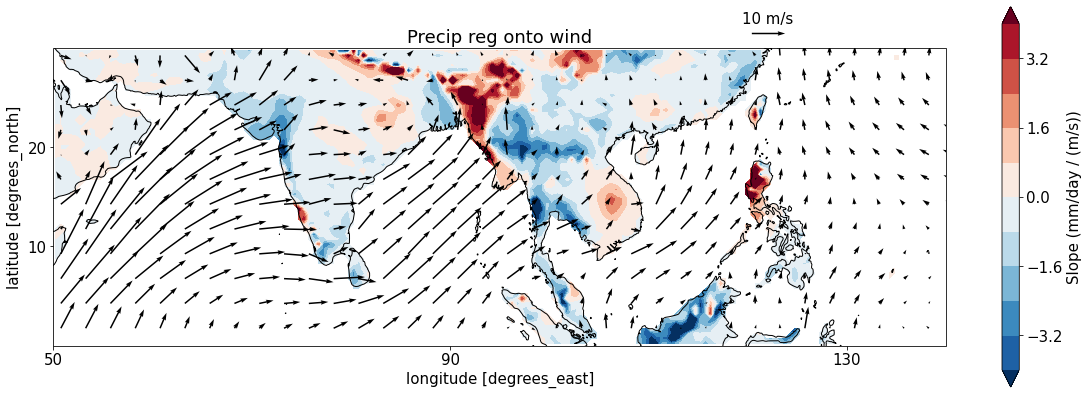

In [97]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

prregwind.slope.plot.contourf(ax=ax1,levels=np.linspace(-4,4,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day / (m/s))'})
#topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

u = era5100u_jja_yearly_1960_2020.mean('year')
v = era5100v_jja_yearly_1960_2020.mean('year')
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=10
m=n
ibeg=3
iend=-1
Q=ax1.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.3,width=1.5,units='dots',transform=ccrs.PlateCarree())
qk = ax1.quiverkey(Q, 0.8, 1.05, 10, r'10 m/s', labelpos='N',
                coordinates='axes',color='k')
ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)

plt.title('Precip reg onto wind')

In [55]:
%time windreg = linregress_xr_2(era5windspeed.year,era5windspeed,dim='year')
windreg_masked = (windreg.slope) / fdr_xr_2d(windreg.pvalue,0.1)

CPU times: user 1.26 s, sys: 209 ms, total: 1.47 s
Wall time: 582 ms


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Wind speed trend with FDR')

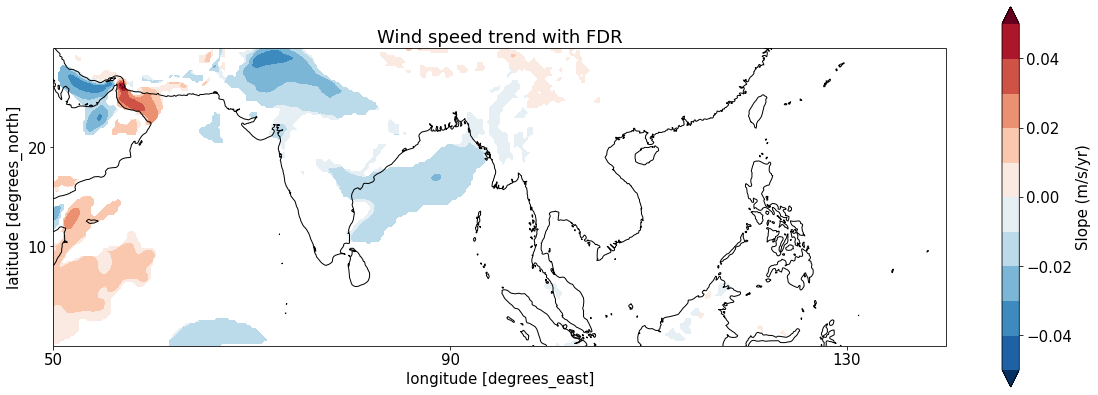

In [85]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

windreg_masked.plot.contourf(ax=ax1,levels=np.linspace(-0.05,0.05,11),transform=ccrs.PlateCarree(),extend='both',cbar_kwargs={'shrink':0.7,'label':'Slope (m/s/yr)'})

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)

plt.title('Wind speed trend with FDR')

Text(0.5, 1.0, 'Wind speed trend')

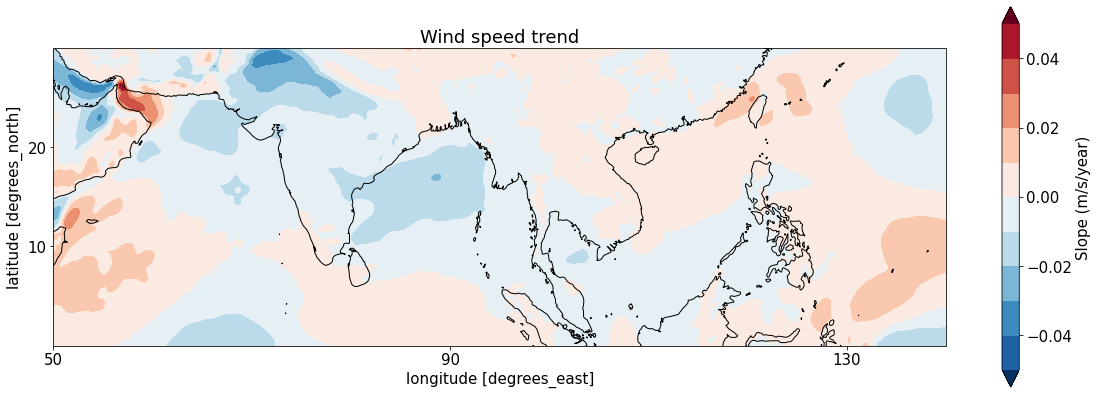

In [77]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

windreg.slope.plot.contourf(ax=ax1,levels=np.linspace(-0.05,0.05,11),transform=ccrs.PlateCarree(),extend='both',cbar_kwargs={'shrink':0.7,'label':'Slope (m/s/year)'})
#topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)

plt.title('Wind speed trend')

In [100]:
%time prreg = linregress_xr_2(cru_pr_jja_yearly_1960_2020.year,cru_pr_jja_yearly_1960_2020,dim='year')
prreg_masked = (prreg.slope) / fdr_xr_2d(prreg.pvalue,0.1)

CPU times: user 260 ms, sys: 177 ms, total: 436 ms
Wall time: 435 ms


Text(0.5, 1.0, 'precip trend with FDR')

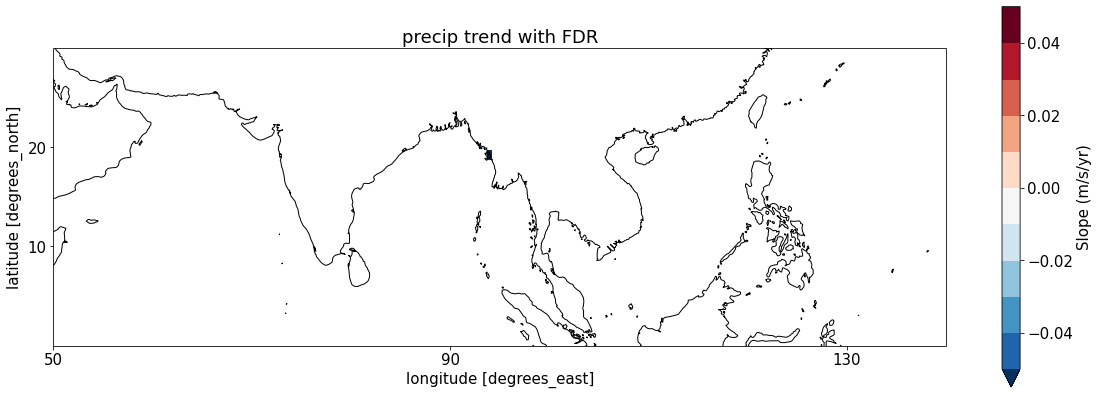

In [101]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

prreg_masked.plot.contourf(ax=ax1,levels=np.linspace(-0.05,0.05,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (m/s/yr)'})

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)

plt.title('precip trend with FDR')

Text(0.5, 1.0, 'precip trend with p<0.05')

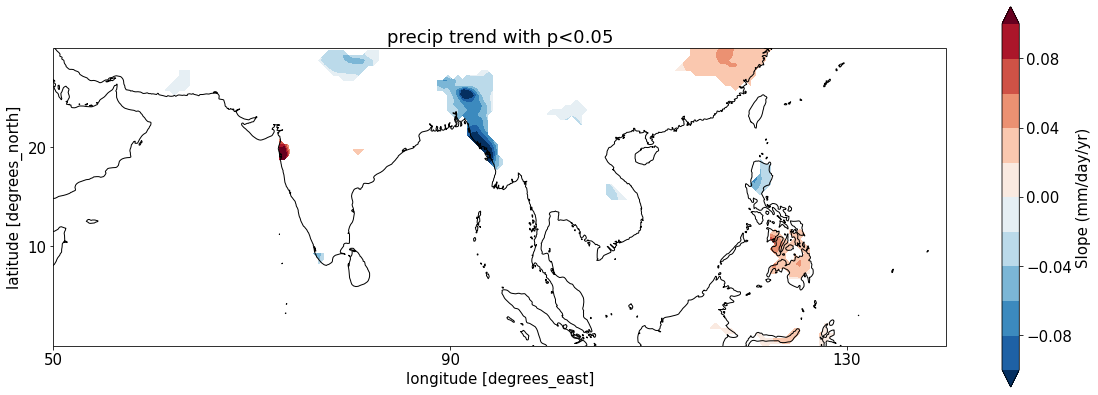

In [104]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

((prreg.slope) / (prreg.pvalue<0.05)).plot.contourf(ax=ax1,levels=np.linspace(-0.1,0.1,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day/yr)'})

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)

plt.title('precip trend with p<0.05')

Text(0.5, 1.0, 'Precip trend')

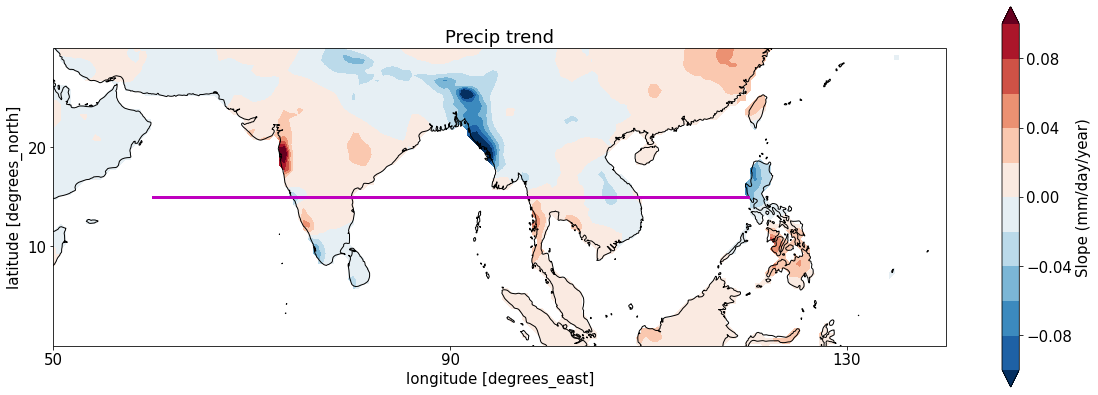

In [105]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

prreg.slope.plot.contourf(ax=ax1,levels=np.linspace(-0.1,0.1,11),transform=ccrs.PlateCarree(),extend='both',cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day/year)'})
#topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.plot([60,120],[15,15],color='m',linewidth=3)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)

plt.title('Precip trend')

# With ERA5 precip

In [120]:
%time era5pr_monthly_1960_1978 = 1000*e5_monthly_timeseries("128_228_tp",years=range(1960,1979),box=[50,160,0,30])
%time era5pr_monthly_1979_2020 = 1000*e5_monthly_timeseries("128_228_tp",years=range(1979,2021),box=[50,160,0,30])
era5pr_monthly_1960_2020 = xr.concat((era5pr_monthly_1960_1978,era5pr_monthly_1979_2020),dim='time')
era5pr_jja_yearly_1960_2020 = sel_jja(era5pr_monthly_1960_2020)


0.1404099464416504
CPU times: user 489 ms, sys: 146 ms, total: 634 ms
Wall time: 492 ms
2.2105135917663574
CPU times: user 2.85 s, sys: 331 ms, total: 3.18 s
Wall time: 2.84 s


In [121]:
%time era5prregwind = linregress_xr_2(era5windspeed,era5pr_jja_yearly_1960_2020,dim='year')
era5prregwind_masked = (era5prregwind.slope) / fdr_xr_2d(era5prregwind.pvalue,0.1)

CPU times: user 2.33 s, sys: 269 ms, total: 2.59 s
Wall time: 1.11 s


In [122]:
%time era5prreg = linregress_xr_2(era5pr_jja_yearly_1960_2020.year,era5pr_jja_yearly_1960_2020,dim='year')
era5prreg_masked = (era5prreg.slope) / fdr_xr_2d(era5prreg.pvalue,0.1)

CPU times: user 748 ms, sys: 98.6 ms, total: 847 ms
Wall time: 376 ms


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Text(0.5, 1.0, 'Precip reg onto wind with fdr')

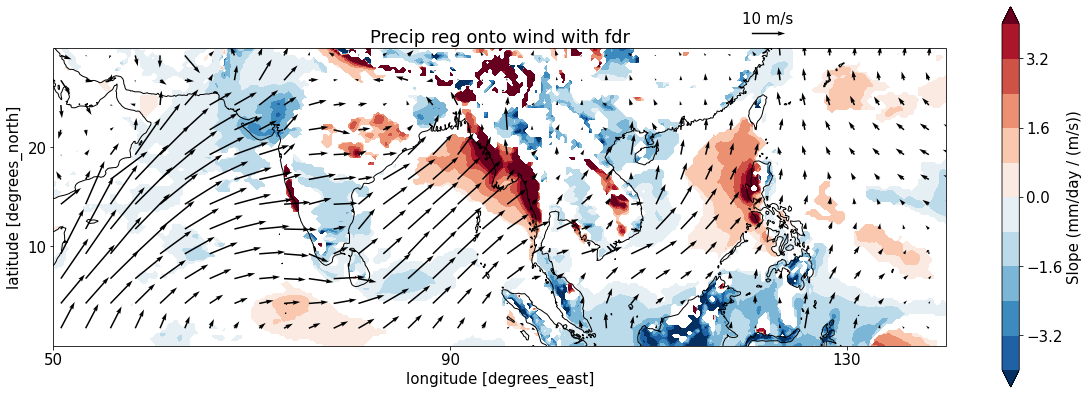

In [123]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

era5prregwind_masked.plot.contourf(ax=ax1,levels=np.linspace(-4,4,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day / (m/s))'})
#topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

u = era5100u_jja_yearly_1960_2020.mean('year')
v = era5100v_jja_yearly_1960_2020.mean('year')
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=10
m=n
ibeg=3
iend=-1
Q=ax1.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.3,width=1.5,units='dots',transform=ccrs.PlateCarree())
qk = ax1.quiverkey(Q, 0.8, 1.05, 10, r'10 m/s', labelpos='N',
                coordinates='axes',color='k')

ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)


plt.title('Precip reg onto wind with fdr')

Text(0.5, 1.0, 'Precip reg onto wind')

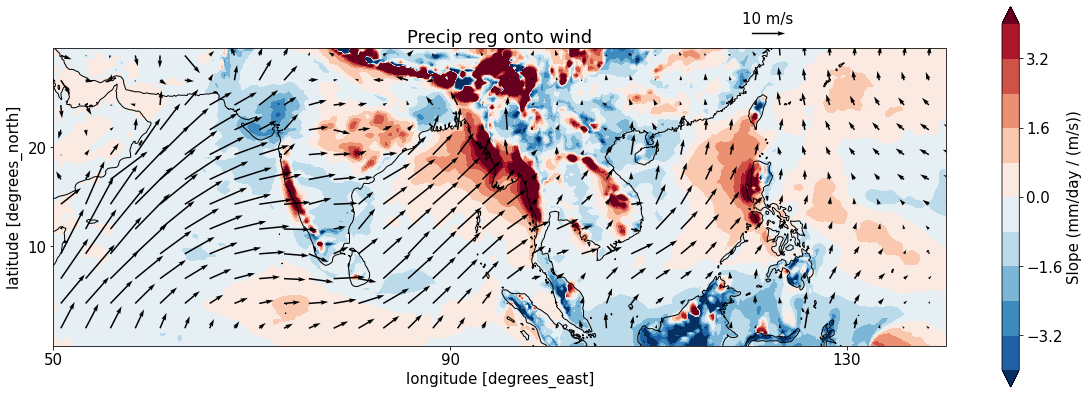

In [125]:
fig,ax1 = plt.subplots(1,1,figsize=(20,10),subplot_kw={'projection': ccrs.PlateCarree()})

lon1,lon2 = 50,160
lat = 15

era5prregwind.slope.plot.contourf(ax=ax1,levels=np.linspace(-4,4,11),transform=ccrs.PlateCarree(),cbar_kwargs={'shrink':0.7,'label':'Slope (mm/day / (m/s))'})
#topo_midres.sel(latitude=slice(30,0),longitude=slice(lon1,lon2)).plot.contour(ax=ax1,levels=[500.],colors=['sienna'],transform=ccrs.PlateCarree())

u = era5100u_jja_yearly_1960_2020.mean('year')
v = era5100v_jja_yearly_1960_2020.mean('year')
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
n=10
m=n
ibeg=3
iend=-1
Q=ax1.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",scale=0.3,width=1.5,units='dots',transform=ccrs.PlateCarree())
qk = ax1.quiverkey(Q, 0.8, 1.05, 10, r'10 m/s', labelpos='N',
                coordinates='axes',color='k')
ax1.coastlines()
ax1.set_xlim(lon1,lon2);ax1.set_ylim(0,30)
ax1.set_title("")
ax1.set_xticks(range(50,140,40), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10,30,10), crs=ccrs.PlateCarree())
ax1.set_ylim(0,30)
ax1.set_xlim(50,140)

plt.title('Precip reg onto wind')